In [72]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,kernel_pca
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import math
% matplotlib inline

In [2]:
raw_train_data=pd.read_csv("../../../Users/sreek/Documents/wer_ai/case-studies/train.tsv",delimiter='\t')


In [117]:
raw_train_dropped.shape

(4632, 254)

 Rows where numerical values ar NAN will be imputed while rows where
categorical values are missing will be dropped.Dropping  rows where columns f_61,f_121,f_215, f_237 have null values.

In [3]:
raw_train_dropped=raw_train_data.dropna(subset=['f_61','f_121','f_215','f_237'])

In [ ]:
raw_train_dropped.shape

In [4]:
del raw_train_data

In [5]:
test_data=pd.read_csv("../../../Users/sreek/Documents/wer_ai/case-studies/test.tsv",delimiter='\t')

In [5]:
target_data=raw_train_dropped.target

In [6]:
raw_train_dropped.drop('target',axis=1,inplace=True)

# numerical features

In [7]:
X_train_num=raw_train_dropped.loc[:,raw_train_dropped.dtypes =='float64']

# categorical features

In [9]:
X_train_cat=raw_train_dropped.loc[:,raw_train_dropped.dtypes == object]

In [10]:
cat_features=X_train_cat.columns

Hashing categorical columns

In [11]:
def feature_hash(df, max_size=20):
    for col in cat_features:
        df[col+"_hash"] = df[col].apply(lambda x: hash(x)%max_size)
    return df

In [12]:
X_train_cat_new=feature_hash(X_train_cat)

C:\python\pyLibs\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [13]:
X_train_cat_new.drop(['f_61','f_121','f_215','f_237'],axis=1,inplace=True)

C:\python\pyLibs\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
X_train_cat_scaled=StandardScaler().fit_transform(X_train_cat_new.values)

C:\Users\sreek\AppData\Roaming\Python\Python35\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\sreek\AppData\Roaming\Python\Python35\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Imputing missing numerical values

In [ ]:
imputer=Imputer()

In [15]:
X_train_num_imputed=imputer.fit_transform(X_train_num.values)

In [16]:
X_train_num_scaled=StandardScaler().fit_transform(X_train_num_imputed)

In [17]:
m_train=np.hstack([X_train_num_scaled,X_train_cat_scaled])

In [55]:
# from sklearn.manifold import LocallyLinearEmbedding
# lle=LocallyLinearEmbedding(n_components=2,n_neighbors=10)
# m_train_reduced=lle.fit_transform(m_train)

In [ ]:
# rnd_pca=PCA(n_components=100,svd_solver='randomized')
# m_train_reduced=rnd_pca(m_train)

In [18]:
#pca=PCA(n_components=0.95)
#m_train_reduced=pca.fit_transform(m_train)
#np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [111]:
kpca=kernel_pca.KernelPCA(n_components=9,fit_inverse_transform=True)
m_train_kpca_reduced=kpca.fit_transform(m_train)

In [112]:
m_train_inversed=kpca.inverse_transform(m_train_kpca_reduced)

(-5.0, 5.0, -5.0, 5.0)

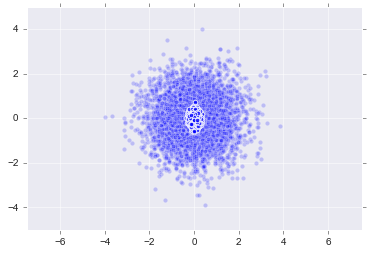

In [113]:
plt.scatter(m_train[:, 0], m_train[:, 1], alpha=0.2)
plt.scatter(m_train_inversed[:, 0], m_train_inversed[:, 1], alpha=0.8)
plt.axis('equal')

# Light points are original values while dark points are projected version. It appears that due to dimensionality we are losing more information (information loss ) there by impacting the model performance. 

In [56]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'eval_metric': 'rmse',
    'max_depth': 17, 
    'learning_rate': 0.10,
    'verbose': 0 
    }
n_estimators = 100


[1]	training's l2: 24.5036	valid_1's l2: 27.9392
Training until validation scores don't improve for 20 rounds.
[2]	training's l2: 22.3058	valid_1's l2: 25.7062
[3]	training's l2: 20.4068	valid_1's l2: 23.8014
[4]	training's l2: 18.8805	valid_1's l2: 22.3022
[5]	training's l2: 17.5646	valid_1's l2: 21.0486
[6]	training's l2: 16.4266	valid_1's l2: 20.0041
[7]	training's l2: 15.2652	valid_1's l2: 19.0002
[8]	training's l2: 14.4154	valid_1's l2: 18.1007
[9]	training's l2: 13.5965	valid_1's l2: 17.1685
[10]	training's l2: 12.9471	valid_1's l2: 16.6614
[11]	training's l2: 12.1685	valid_1's l2: 15.7766
[12]	training's l2: 11.5662	valid_1's l2: 15.2133
[13]	training's l2: 11.0297	valid_1's l2: 14.7169
[14]	training's l2: 10.43	valid_1's l2: 14.2144
[15]	training's l2: 10.0212	valid_1's l2: 13.8557
[16]	training's l2: 9.50336	valid_1's l2: 13.3873
[17]	training's l2: 9.09521	valid_1's l2: 13.0295
[18]	training's l2: 8.5833	valid_1's l2: 12.4161
[19]	training's l2: 8.25614	valid_1's l2: 12.1535


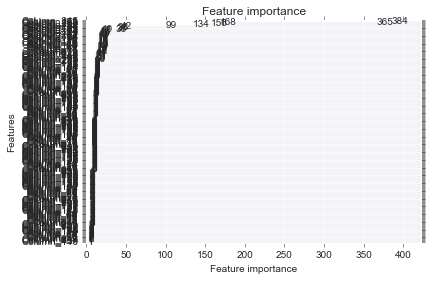

In [115]:
from sklearn.metrics import explained_variance_score
from lightgbm import plot_importance
n_iters = 5
for i in range(n_iters): 
    x_train, x_valid, y_train, y_valid = train_test_split(m_train, target_data, test_size=0.15, random_state=i)
    d_train = lgbm.Dataset(x_train, label=y_train)
    d_valid = lgbm.Dataset(x_valid, label=y_valid)
    watchlist = [d_valid]

    model = lgbm.train(params, d_train, n_estimators,valid_sets=[d_train,d_valid], early_stopping_rounds=20, verbose_eval=1)

    preds = model.predict(x_valid)
    
  

#print('rmse of prediction is:', mean_squared_error(y_valid, preds) ** 0.5)  


print("RMSE of preds in ",explained_variance_score(y_valid,preds))
#print("Feature importance is ",model.feature_importance())

plot_importance(model)
plt.show()